In [ ]:
import os

!apt-get -qq update; apt-get install -y python-dev libfftw3-dev libeigen3-dev ffmpeg pybind11-dev
!pip install rmjarvis.eigency>=1.77.1
!pip install galsim --no-cache-dir
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import galsim 
import scipy as sp

# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-dev is already the newest version (2.7.15~rc1-1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following additional packages will be installed:
  libfftw3-bin libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libeigen3-doc libmrpt-dev libfftw3-doc pybind11-doc
The following NEW packages will be installed:
  libeigen3-dev libfftw3-bin libfftw3-dev libfftw3-long3 libfftw3-quad3
  libfftw3-single3 pybind11-dev
0 upgraded, 7 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,648 kB of archives.
After this operation, 28.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libfftw3-long3 amd64 3.3.7-1 [308 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libfftw3-quad3 amd64 3.3.7-1 [552 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libfftw3-single3 amd64 3.3.7-1 [764

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/denoising

Mounted at /content/drive
/content/drive/MyDrive/denoising


In [ ]:
import itertools
np.random.seed(seed=10)

# Define the ellipticities for each stars (e1s and e2s), 
# and the constant shape of the stars before the shearing (sigma, fwhm_psf)
e1 = np.linspace(-0.15, 0.15, num=15, endpoint=True)
e2 = np.linspace(-0.15, 0.15, num=15, endpoint=True)
R2 = np.random.uniform(2.5, 8, 10)
sigma = np.sqrt(R2/2)
fwhm_psf = (2*np.sqrt(2*np.log(2)))*sigma
SNR = np.linspace(10, 200, 19, dtype=int)
SNR = np.append(SNR, 0)

# Generate the 1000 combinations of e1, e2 and fwhm

es = list(itertools.product(*[e1, e2, fwhm_psf, SNR]))
e1s = np.array([a for a,b,c,d in es])
e2s = np.array([b for a,b,c,d in es]) 
fwhms = np.array([c for a,b,c,d in es])
snr = np.array([d for a,b,c,d in es])

## Ou alors garder un nombre d'images à 25 000 et faire n bins dedans

In [ ]:
# Parameters
image_size = 64
psf_flux = 1.
beta_psf =  4.8 # 4.8# 2.5
pix_scale = 0.187
#desired_SNR = 30

# Generate the vignets
new_vignets_noiseless = np.zeros((e1s.shape[0],image_size,image_size))
new_vignets_with_noise = np.zeros((e1s.shape[0],image_size,image_size))
new_e1_HSM = np.zeros(e1s.shape)
new_e2_HSM = np.zeros(e1s.shape)
new_R2_HSM = np.zeros(e1s.shape)
for it in range(e1s.shape[0]):
    
    # PSF generation. Define size
    psf = galsim.Moffat(fwhm=fwhms[it]*pix_scale, beta=beta_psf)
#     psf = galsim.Gaussian(fwhm=fwhms[it]*pix_scale)#, beta=beta_psf)
    # Define the Flux
    psf = psf.withFlux(psf_flux)
    # Define the shear
    psf = psf.shear(g1=e1s[it], g2=e2s[it])
    # Draw the PSF on a vignet
    noisy_image_epsf = galsim.ImageF(image_size, image_size)
    # Define intrapixel shift (uniform distribution in [-0.5,0.5])
    rand_shift = np.random.rand(2)-0.5
    psf.drawImage(image=noisy_image_epsf, offset=rand_shift, scale=pix_scale)

    sigma_noise = np.sqrt((np.sum(noisy_image_epsf.array**2))/(snr[it] * image_size**2))
    # Generate Gaussian noise for the PSF 
    gaussian_noise = galsim.GaussianNoise(sigma=sigma_noise)
    
    # Before adding the noise, we measure the ellipticity components
#     my_moments = noisy_image_epsf.FindAdaptiveMom()
    my_moments = galsim.hsm.FindAdaptiveMom(noisy_image_epsf)
    new_e1_HSM[it] = my_moments.observed_shape.g1
    new_e2_HSM[it] = my_moments.observed_shape.g2
    new_R2_HSM[it] = my_moments.moments_sigma

    # Save images before adding the noise

    new_vignets_noiseless[it,:,:] = noisy_image_epsf.array
    
    # Add Gaussian noise to the PSF 
    
    if snr[it]>0:
      noisy_image_epsf.addNoise(gaussian_noise)
      new_vignets_with_noise[it,:,:] = noisy_image_epsf.array
    else:
      new_vignets_with_noise[it,:,:] = noisy_image_epsf.array
    
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


In [ ]:
train_dic = {'VIGNET_NOISELESS':new_vignets_noiseless,'VIGNETS_WITH_NOISE':new_vignets_with_noise,  
             'TRUE_E1_HSM':new_e1_HSM,'TRUE_E2_HSM':new_e2_HSM,'TRUE_R2_HSM':new_R2_HSM}



First star's ellipticity is: (-0.14649270856248162,-0.14651650156755328)
Second star's ellipticity is: (-0.14235093523191342,-0.06099592864077762)


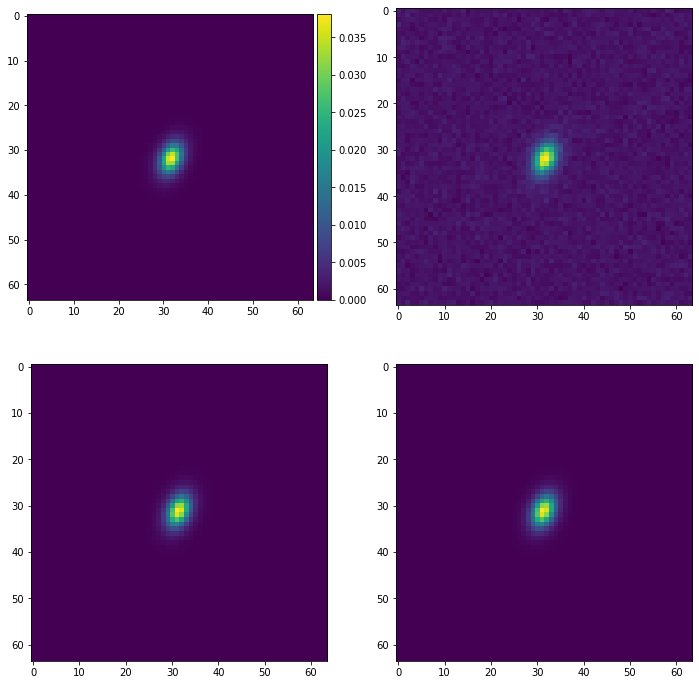

In [ ]:
one_star_noiseless = new_vignets_noiseless[0,:,:]
one_star_noise = new_vignets_with_noise[0,:,:]
second_star_noiseless = new_vignets_noiseless[19,:,:]
second_star_noise = new_vignets_with_noise[19,:,:]

fig = plt.figure(num=0, figsize=(12,12))
ax1 = fig.add_subplot(2,2,1)
im1 = ax1.imshow(one_star_noiseless, interpolation='None')
ax2 = fig.add_subplot(2,2,2)
im2 = ax2.imshow(one_star_noise, interpolation='None')
ax3 = fig.add_subplot(2,2,3)
im3 = ax3.imshow(second_star_noiseless, interpolation='None')
ax4 = fig.add_subplot(2,2,4)
im4 = ax4.imshow(second_star_noise, interpolation='None')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

print("First star's ellipticity is: ({},{})".format(new_e1_HSM[0], new_e2_HSM[0]))
print("Second star's ellipticity is: ({},{})".format(new_e1_HSM[999], new_e2_HSM[999]))

In [ ]:
np.save('datasets/dataset_45_64.npy', train_dic, allow_pickle=True)